**TO-DO**
* verificar se para todos os valores nulos na operation, todos os k_symbol são interested credited
* verificar se a k_symbol acrescenta informação relevante à operation (sem ser os valores nulos corresponderem ao interested credited), visto que esta apenas especifica mais algumas operações
* agrupar withdrawal in cash e withdrawal do type (testar juntos e separados para ver os resultados)
* retirar coluna account - tem muitos valores a zero (verificar, pois poderá ser devido a um erro) (testar primeiro sem valores a zero e depois sem a coluna)
* retirar coluna bank
* provavelmente retirar a coluna type, pois poderá não acrescentar valor aos dados nada de relevante que já não esteja na coluna operation (testar). Coluna type é uma generalização da operation logo apenas simplifica a informação e não acrescenta nada.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

In [2]:
def dataset(x, missing = ""):
    return pd.read_csv('Dataset/' + x + '.csv', sep = ';', low_memory = False, na_values = missing_values).rename(str.strip, axis = 'columns')

In [3]:
missing_values = ['?', 'NA', '']
account_data = dataset('account', missing_values)
client_data = dataset('client', missing_values)
disp_data = dataset('disp', missing_values)
district_data = dataset('district', missing_values)
card_train = dataset('card_train', missing_values)
card_test = dataset('card_test')
loan_train = dataset('loan_train', missing_values)
loan_test = dataset('loan_test')
trans_train = dataset('trans_train', missing_values)
trans_test = dataset('trans_test')

In [4]:
# Removing name and region from district
district_data.drop(['name', 'region'], axis=1, inplace=True)

# only owner can issue permanent orders and ask for a loan
disp_owners = disp_data[disp_data.type.eq('OWNER')]
disp_owners.drop(['type'], axis=1, inplace=True)

C:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
# Normalize birthday dates and add a new column (Genre) to distinguish

birth_dates = client_data['birth_number']
dates_parsed = []
genre = []
for date in birth_dates:
    month = int(str(date)[2:4])
    if month > 12:
        genre.append(0)
        month = month - 50
        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
    else:
        #print('AAAA: ' + str(month))
        if month < 10:
            month = '0' + str(month)
            #print('BBBB: ' + str(month))
        else:
            month = str(month)
        genre.append(1)
    dates_parsed.append(str(date)[:2] + '-' + month + '-' + str(date)[4:])
    
ages = []
for date in dates_parsed:
    born_year = '19' + date[:2]
    age = 2021 - int(born_year)
    ages.append(age)
    
client_data = client_data.drop(['birth_number'], axis = 1)
client_data['age'] = ages
client_data['genre'] = genre
client_data.head()

,client_id,district_id,age,genre
0,1,18,51,0
1,2,1,76,1
2,3,1,81,0
3,4,5,65,1
4,5,5,61,0


In [6]:
# build train dataset

train_data = loan_train
train_data = pd.merge(train_data, trans_train, on = 'account_id', suffixes = ('', '_trans'))
train_data = pd.merge(train_data, account_data, on = 'account_id', suffixes = ('', '_account'))
#train_data = train_data.dropna()
train_data = pd.merge(train_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))
train_data = pd.merge(train_data, disp_owners, on = 'account_id', suffixes = ('', '_disp'))
train_data = pd.merge(train_data, card_train, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
train_data = pd.merge(train_data, client_data, on = 'client_id', suffixes = ('', '_client'))
train_data = train_data.drop(['district_id_client'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 39 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           24494 non-null  float64
 1   account_id                                        24494 non-null  float64
 2   date                                              24494 non-null  float64
 3   amount                                            24494 non-null  float64
 4   duration                                          24494 non-null  float64
 5   payments                                          24494 non-null  float64
 6   status                                            24494 non-null  float64
 7   trans_id                                          24494 non-null  float64
 8   date_trans                                        24494 non-null  float64
 9   type             

In [7]:
train_data.head()

,loan_id,account_id,date,amount,duration,payments,status,trans_id,date_trans,type,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,disp_id,client_id,card_id,type_card,issued,age,genre
0,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,523621.0,930322.0,credit,...,100.0,2985.0,2804.0,2166,2166.0,NaN,NaN,NaN,74,0
1,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524054.0,930421.0,credit,...,100.0,2985.0,2804.0,2166,2166.0,NaN,NaN,NaN,74,0
2,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524055.0,930521.0,credit,...,100.0,2985.0,2804.0,2166,2166.0,NaN,NaN,NaN,74,0
3,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524056.0,930620.0,credit,...,100.0,2985.0,2804.0,2166,2166.0,NaN,NaN,NaN,74,0
4,6903.0,9337.0,940604.0,52128.0,24.0,2172.0,1.0,2820215.0,930913.0,credit,...,100.0,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,62,0


In [8]:
# build test dataset

test_data = loan_test
test_data = pd.merge(test_data, trans_test, on = 'account_id', suffixes = ('', '_trans'))
test_data = pd.merge(test_data, account_data, on = 'account_id', suffixes = ('', '_account'))
test_data = pd.merge(test_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))
test_data = pd.merge(test_data, disp_owners, on = 'account_id', suffixes = ('', '_disp'))
test_data = pd.merge(test_data, card_test, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
test_data = pd.merge(test_data, client_data, on = 'client_id', suffixes = ('', '_client'))
test_data = test_data.drop(['district_id_client'], axis=1)
test_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30200 entries, 0 to 30199
Data columns (total 39 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           30200 non-null  int64  
 1   account_id                                        30200 non-null  int64  
 2   date                                              30200 non-null  int64  
 3   amount                                            30200 non-null  int64  
 4   duration                                          30200 non-null  int64  
 5   payments                                          30200 non-null  int64  
 6   status                                            0 non-null      float64
 7   trans_id                                          30200 non-null  int64  
 8   date_trans                                        30200 non-null  int64  
 9   type             

In [9]:
test_data.head()

,loan_id,account_id,date,amount,duration,payments,status,trans_id,date_trans,type,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,disp_id,client_id,card_id,type_card,issued,age,genre
0,5895,4473,970103,93960,60,1566,NaN,1309867,951009,credit,...,132,2080.0,2122,5395,5395,NaN,NaN,NaN,59,1
1,5895,4473,970103,93960,60,1566,NaN,1309878,951107,credit,...,132,2080.0,2122,5395,5395,NaN,NaN,NaN,59,1
2,5895,4473,970103,93960,60,1566,NaN,1310161,951108,credit,...,132,2080.0,2122,5395,5395,NaN,NaN,NaN,59,1
3,5895,4473,970103,93960,60,1566,NaN,3664951,951130,credit,...,132,2080.0,2122,5395,5395,NaN,NaN,NaN,59,1
4,5895,4473,970103,93960,60,1566,NaN,1309879,951207,credit,...,132,2080.0,2122,5395,5395,NaN,NaN,NaN,59,1


In [10]:
# Remove all dates from data, because only the number doesn't make sense. Probably transform it to age?
train_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)
test_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)

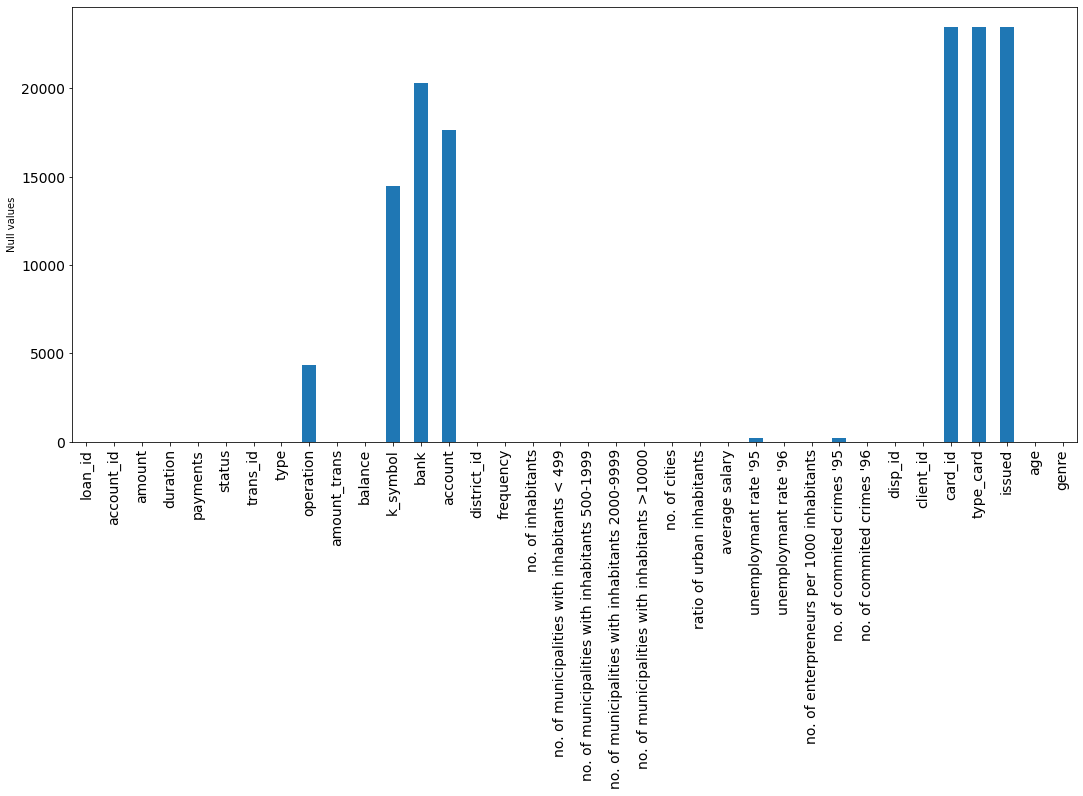

In [11]:
# Null values for each attribute
train_data.isnull().sum().plot(kind='bar', figsize=(18,8), fontsize=14,);
plt.ylabel('Null values');

In [12]:
print('Null values unemploymant rate in \'95:' + str(district_data['unemploymant rate \'95'].isnull().sum()))
print()
print('Null values no. of commited crimes \'95 :' + str(district_data['no. of commited crimes \'95'].isnull().sum()))
print()

Null values unemploymant rate in '95:1

Null values no. of commited crimes '95 :1



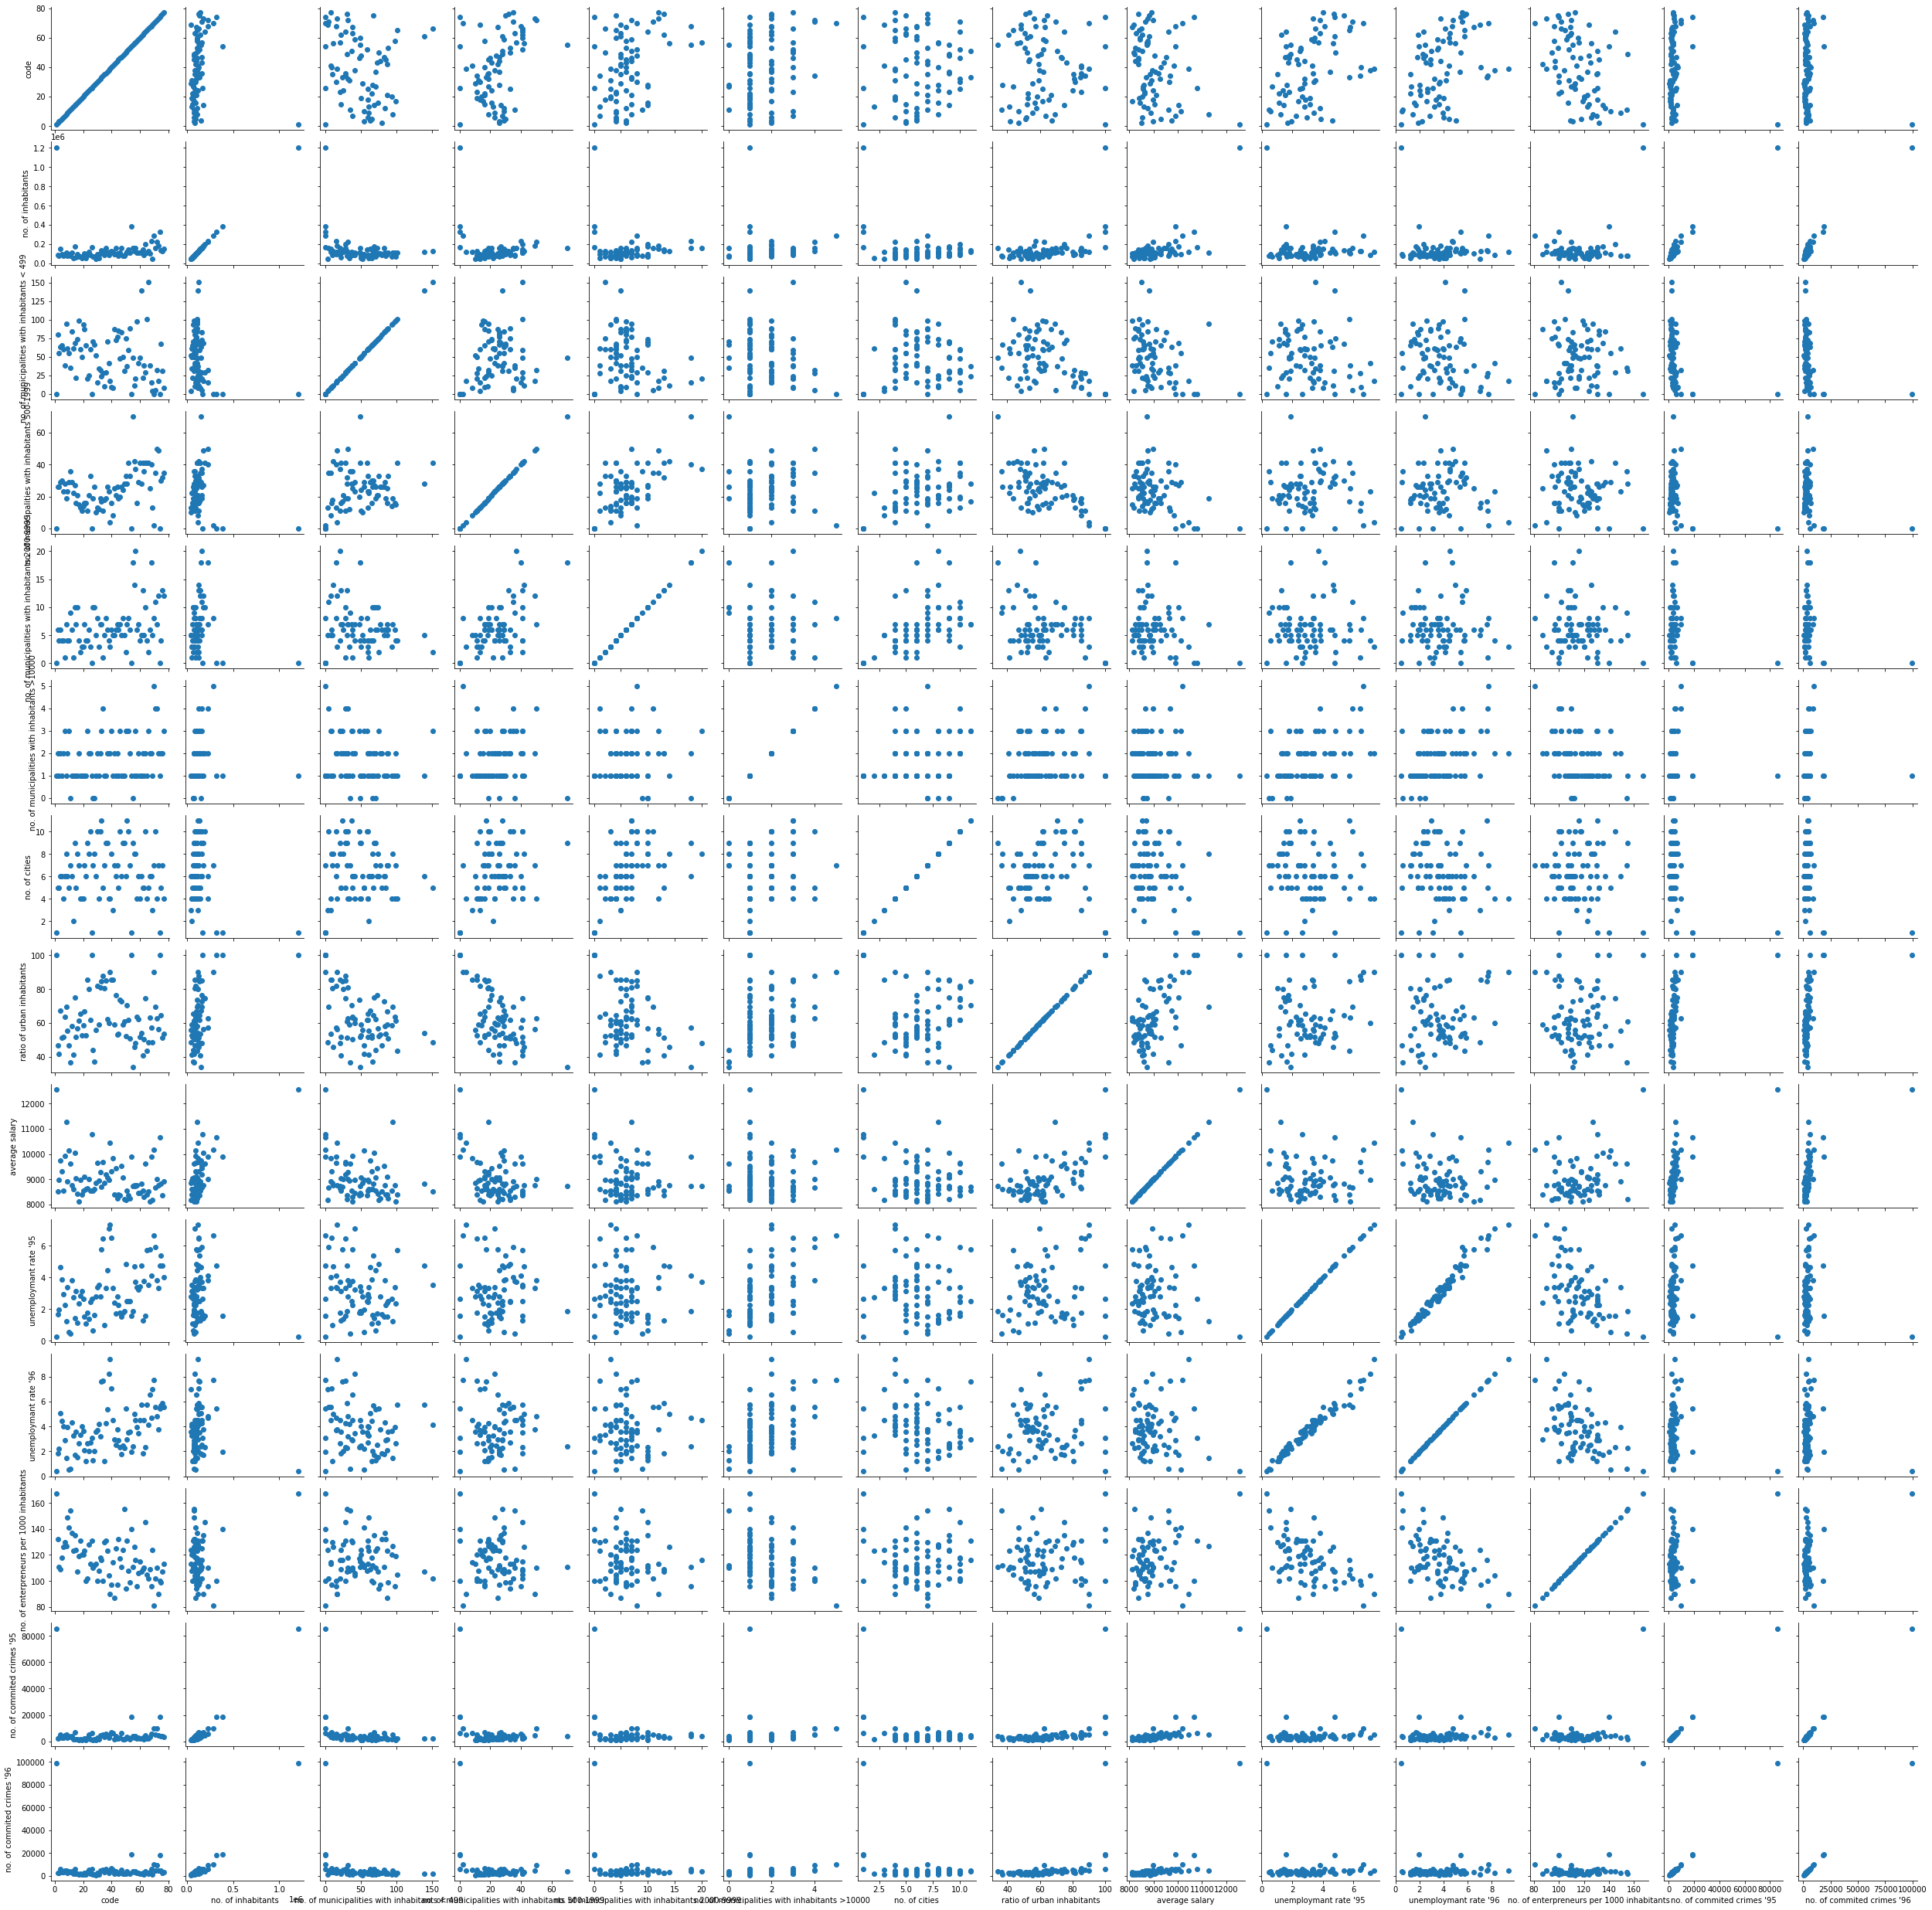

In [13]:
district_scatter_plot = sb.PairGrid(district_data)
district_scatter_plot.map(plt.scatter)

(array([ 4., 13., 10., 13., 15.,  5.,  6.,  4.,  4.,  2.]),
 array([0.29 , 0.995, 1.7  , 2.405, 3.11 , 3.815, 4.52 , 5.225, 5.93 ,
        6.635, 7.34 ]),
 <BarContainer object of 10 artists>)

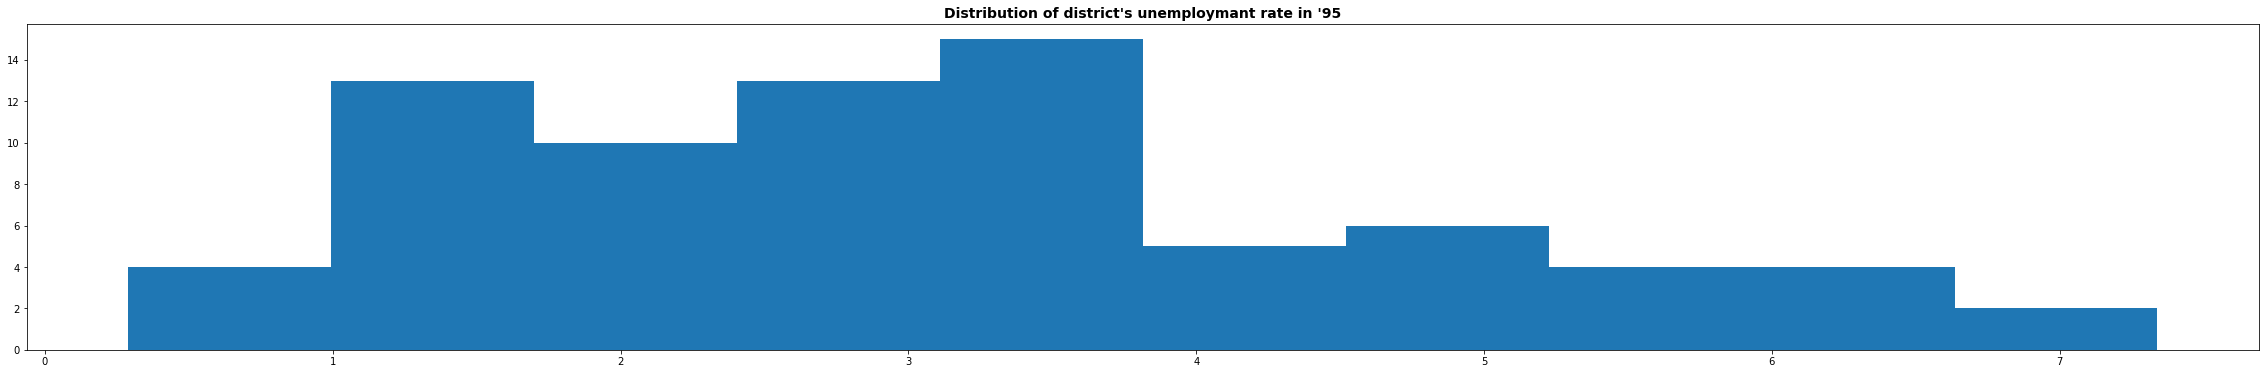

In [14]:
plt.figure(figsize=(40,6))
plt.title('Distribution of district\'s unemploymant rate in \'95', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.hist(district_data['unemploymant rate \'95'])

(array([71.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  818. ,  9303.9, 17789.8, 26275.7, 34761.6, 43247.5, 51733.4,
        60219.3, 68705.2, 77191.1, 85677. ]),
 <BarContainer object of 10 artists>)

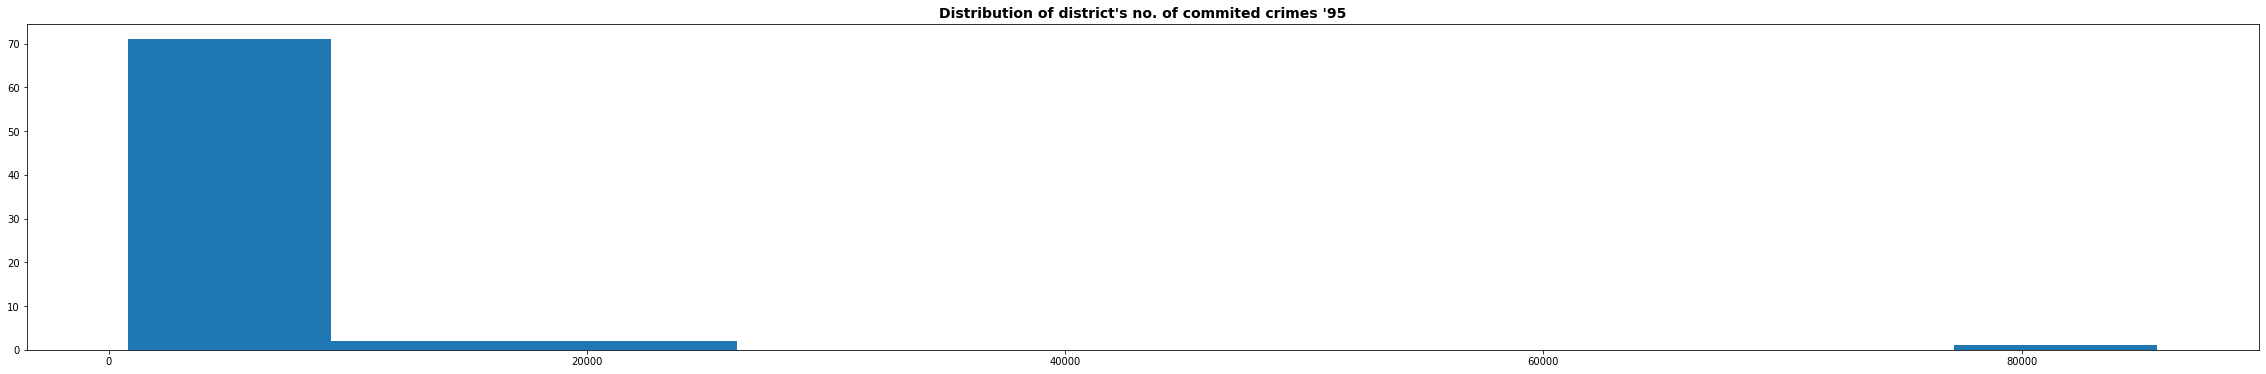

In [15]:
plt.figure(figsize=(40,6))
plt.title('Distribution of district\'s no. of commited crimes \'95', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.hist(district_data['no. of commited crimes \'95'])

In [16]:
# Fill null values in district's unemploymant rate in '95 and district's no. of commited crimes '95
# See if it is better to use median or mean 

train_data['unemploymant rate \'95'].fillna(train_data['unemploymant rate \'95'].median(), inplace=True)

train_data['no. of commited crimes \'95'].fillna(train_data['no. of commited crimes \'95'].mean(), inplace=True)

In [17]:
print(train_data.operation.value_counts())
print('Null values: ' + str(train_data.operation.isnull().sum()))
print()
print(train_data.k_symbol.value_counts())
print('Null values: ' + str(train_data.k_symbol.isnull().sum()))
print()
print(train_data.bank.value_counts())
print('Null values: ' + str(train_data.bank.isnull().sum()))
print()
print(train_data.type_card.value_counts())
print('Null values: ' + str(train_data.type_card.isnull().sum()))
print()
print(train_data.type.value_counts())
print('Null values: ' + str(train_data.type.isnull().sum()))
print()

withdrawal in cash              11462
credit in cash                   4506
remittance to another bank       3033
collection from another bank     1139
credit card withdrawal             23
Name: operation, dtype: int64
Null values: 4331

interest credited                        4331
payment for statement                    2528
household                                1724
                                         1001
insurrance payment                        419
sanction interest if negative balance      38
Name: k_symbol, dtype: int64
Null values: 14453

EF    449
YZ    379
ST    375
AB    352
IJ    341
KL    330
GH    328
QR    320
CD    294
UV    287
OP    283
WX    222
MN    212
Name: bank, dtype: int64
Null values: 20322

classic    862
gold        99
junior      77
Name: type_card, dtype: int64
Null values: 23456

withdrawal            13730
credit                 9976
withdrawal in cash      788
Name: type, dtype: int64
Null values: 0



In [18]:
operations_null = train_data[train_data['operation'].isnull()]
operations_null.head()

,loan_id,account_id,amount,duration,payments,status,trans_id,type,operation,amount_trans,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,disp_id,client_id,card_id,type_card,issued,age,genre
7,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3682686.0,credit,NaN,44.1,...,100.0,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,62,0
8,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3456558.0,credit,NaN,44.1,...,100.0,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,62,0
9,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3510168.0,credit,NaN,38.7,...,100.0,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,62,0
11,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3682687.0,credit,NaN,161.9,...,100.0,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,62,0
12,6903.0,9337.0,52128.0,24.0,2172.0,1.0,3456559.0,credit,NaN,162.6,...,100.0,2985.0,2804.0,11189,11497.0,NaN,NaN,NaN,62,0


In [19]:
operations_null.k_symbol.value_counts()

interest credited    4331
Name: k_symbol, dtype: int64

All rows that have 'operation' column with null value have 'interested credited' in 'k_symbol' column.

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 36 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           24494 non-null  float64
 1   account_id                                        24494 non-null  float64
 2   amount                                            24494 non-null  float64
 3   duration                                          24494 non-null  float64
 4   payments                                          24494 non-null  float64
 5   status                                            24494 non-null  float64
 6   trans_id                                          24494 non-null  float64
 7   type                                              24494 non-null  object 
 8   operation                                         20163 non-null  object 
 9   amount_trans     

In [21]:
# needs to be checked
option = 1
if option ==1:
    train_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
elif option==2:
    train_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    train_data.replace('withdrawal in cash', 'withdrawal', inplace=True)
    test_data.replace('withdrawal in cash', 'withdrawal', inplace=True)
elif option==3:
    train_data['operation'].fillna(train_data['k_symbol'], inplace=True)
    test_data['operation'].fillna(test_data['k_symbol'], inplace=True)
    train_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)

In [22]:
train_data = pd.get_dummies(train_data, columns=['frequency'], dtype=bool)
test_data = pd.get_dummies(test_data, columns=['frequency'], dtype=bool)

train_data = pd.get_dummies(train_data, columns=['type_card'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type_card'], dtype = bool)

# train_data = pd.get_dummies(train_data, columns=['type_disp'], dtype = bool)
# test_data = pd.get_dummies(test_data, columns=['type_disp'], dtype = bool)

train_data = pd.get_dummies(train_data, columns=['type'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type'], dtype = bool)

if option != 1:
    train_data = pd.get_dummies(train_data, columns=['operation'], dtype = bool)
    test_data = pd.get_dummies(test_data, columns=['operation'], dtype = bool)

test_data = test_data.drop_duplicates(subset=['loan_id'], keep='first')

#train_data = pd.get_dummies(train_data)
#test_data = pd.get_dummies(test_data)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 37 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           24494 non-null  float64
 1   account_id                                        24494 non-null  float64
 2   amount                                            24494 non-null  float64
 3   duration                                          24494 non-null  float64
 4   payments                                          24494 non-null  float64
 5   status                                            24494 non-null  float64
 6   trans_id                                          24494 non-null  float64
 7   amount_trans                                      24494 non-null  float64
 8   balance                                           24494 non-null  float64
 9   district_id      

In [23]:
train_data.head()

,loan_id,account_id,amount,duration,payments,status,trans_id,amount_trans,balance,district_id,...,genre,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,523621.0,1100.0,1100.0,30.0,...,0,False,False,True,False,False,False,True,False,False
1,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524054.0,9900.0,11000.0,30.0,...,0,False,False,True,False,False,False,True,False,False
2,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524055.0,5800.0,16800.0,30.0,...,0,False,False,True,False,False,False,True,False,False
3,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524056.0,3300.0,20100.0,30.0,...,0,False,False,True,False,False,False,True,False,False
4,6903.0,9337.0,52128.0,24.0,2172.0,1.0,2820215.0,900.0,900.0,30.0,...,0,False,True,False,False,False,False,True,False,False


In [24]:
competition_inputs = test_data.drop(columns=["loan_id", "status"])
test_data = test_data.drop(columns=["status"])
all_ids_comp = test_data['loan_id'].values

train_data_w /test_data_w : train/test data where withdrawals in cash are replaced by withdrawals

3 Dropped columns: ["unemploymant rate '96", "no. of commited crimes '95", "no. of commited crimes '96"]


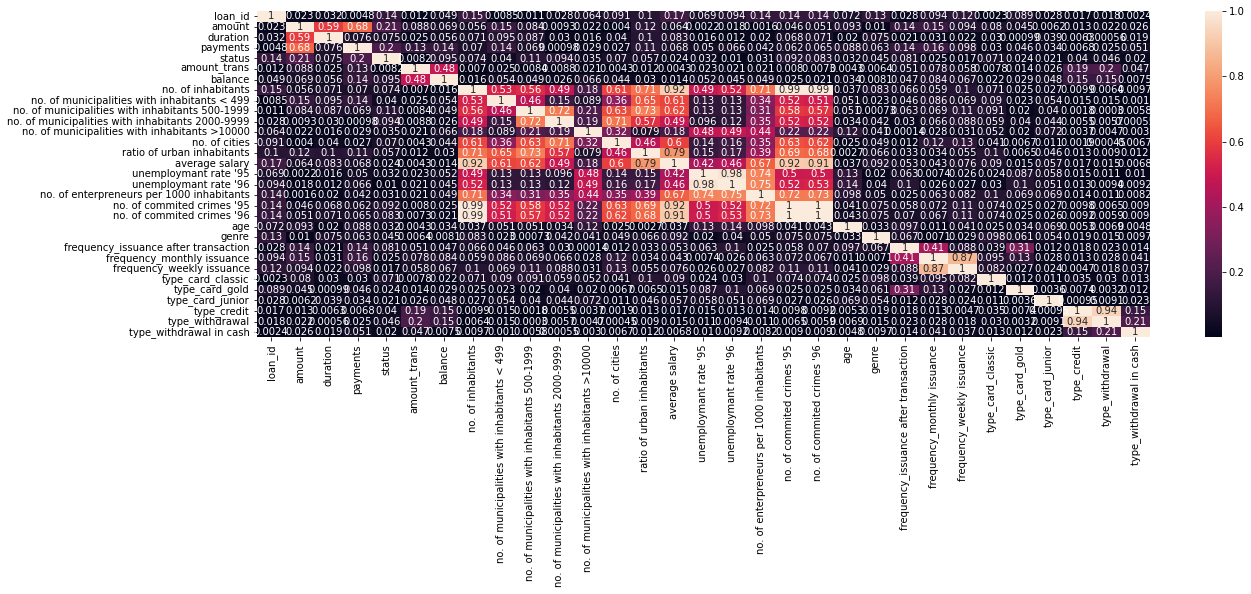

In [25]:
# Dropping ids
#train_data_no_ids = train_data.drop(['loan_id', 'account_id', 'district_id', 'disp_id', 'client_id', 'card_id', 'trans_id'], axis=1)
train_data_no_ids = train_data.drop(['client_id', 'account_id', 'district_id', 'disp_id', 'card_id', 'trans_id'], axis=1)


# Create correlation matrix
corr_matrix = train_data_no_ids.corr().abs()
plt.figure(figsize = (20,6))
sb.heatmap(corr_matrix, annot=True)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
train_data_no_ids.drop(to_drop, axis=1, inplace=True)

print("{} Dropped columns: {}".format(len(to_drop), to_drop) )

In [26]:
train_data_no_ids.head()

,loan_id,amount,duration,payments,status,amount_trans,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,...,genre,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,96396.0,12.0,8033.0,-1.0,1100.0,1100.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
1,5314.0,96396.0,12.0,8033.0,-1.0,9900.0,11000.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
2,5314.0,96396.0,12.0,8033.0,-1.0,5800.0,16800.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
3,5314.0,96396.0,12.0,8033.0,-1.0,3300.0,20100.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
4,6903.0,52128.0,24.0,2172.0,1.0,900.0,900.0,94812.0,15.0,13.0,...,0,False,True,False,False,False,False,True,False,False


In [27]:
# Removing rows with nan values for status
#train_data_no_ids.dropna(subset=["status"], inplace=True)

#print(no_ids.drop_duplicates(inplace=True)
print(train_data_no_ids["status"].value_counts())

 1.0    21524
-1.0     2970
Name: status, dtype: int64


In [28]:
train_data_no_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 28 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           24494 non-null  float64
 1   amount                                            24494 non-null  float64
 2   duration                                          24494 non-null  float64
 3   payments                                          24494 non-null  float64
 4   status                                            24494 non-null  float64
 5   amount_trans                                      24494 non-null  float64
 6   balance                                           24494 non-null  float64
 7   no. of inhabitants                                24494 non-null  float64
 8   no. of municipalities with inhabitants < 499      24494 non-null  float64
 9   no. of municipali

In [29]:
train_data_no_ids.head()

,loan_id,amount,duration,payments,status,amount_trans,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,...,genre,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,96396.0,12.0,8033.0,-1.0,1100.0,1100.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
1,5314.0,96396.0,12.0,8033.0,-1.0,9900.0,11000.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
2,5314.0,96396.0,12.0,8033.0,-1.0,5800.0,16800.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
3,5314.0,96396.0,12.0,8033.0,-1.0,3300.0,20100.0,94812.0,15.0,13.0,...,0,False,False,True,False,False,False,True,False,False
4,6903.0,52128.0,24.0,2172.0,1.0,900.0,900.0,94812.0,15.0,13.0,...,0,False,True,False,False,False,False,True,False,False


In [30]:
# Removing labels and creating another dataset for them
train_data_no_ids = train_data_no_ids.dropna()
default_ind_no = train_data_no_ids.loc[train_data_no_ids['status'] == -1]
default_ind_yes = train_data_no_ids.loc[train_data_no_ids['status'] == 1]

df_minority_upsampled = resample(default_ind_yes, replace=True, n_samples=len(default_ind_no),random_state=123)

train_data_no_ids = pd.concat([default_ind_no, df_minority_upsampled])

train_data_no_ids.status.value_counts()


-1.0    2970
 1.0    2970
Name: status, dtype: int64

In [31]:
all_inputs = train_data_no_ids[train_data_no_ids.columns.drop(['loan_id'])]
all_labels = train_data_no_ids['status'].values

competition_inputs = test_data.drop(columns=["loan_id"])
all_ids_comp = test_data['loan_id'].values

#all_inputs = train_data_no_ids.iloc[:, :-1].values
#all_labels = train_data_no_ids.iloc[:, -1].values

In [32]:
all_inputs.status.value_counts()

-1.0    2970
 1.0    2970
Name: status, dtype: int64

In [33]:
# get a test dataset with 25% of the credit_data_subset
(X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)
#(X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, random_state=1)

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455 entries, 8413 to 6324
Data columns (total 27 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   amount                                            4455 non-null   float64
 1   duration                                          4455 non-null   float64
 2   payments                                          4455 non-null   float64
 3   status                                            4455 non-null   float64
 4   amount_trans                                      4455 non-null   float64
 5   balance                                           4455 non-null   float64
 6   no. of inhabitants                                4455 non-null   float64
 7   no. of municipalities with inhabitants < 499      4455 non-null   float64
 8   no. of municipalities with inhabitants 500-1999   4455 non-null   float64
 9   no. of municipal

**Decision Tree**

Classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       751
         1.0       1.00      1.00      1.00       734

    accuracy                           1.00      1485
   macro avg       1.00      1.00      1.00      1485
weighted avg       1.00      1.00      1.00      1485




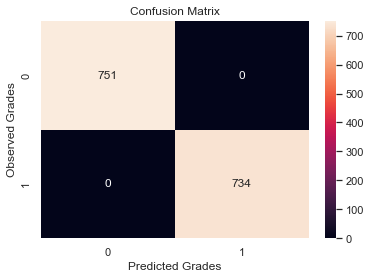

In [35]:
# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(X_train, y_train)

dtc_prediction = decision_tree_classifier.predict(X_test)

dtc_classification_report = classification_report(y_test, dtc_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, dtc_prediction)}\n")

sb.set(font_scale=1.0)
 
ax = plt.subplot()

confusion_matrix_dtc = confusion_matrix(y_test, dtc_prediction)

sb.heatmap(confusion_matrix_dtc, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

**Parameter Tunning**

In [36]:
parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': range(10, 20),
                  'max_features': range(10,20)}

grid_search = GridSearchCV(DecisionTreeClassifier(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Best score: 1.0
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'splitter': 'random'}
Best estimator: DecisionTreeClassifier(max_depth=10, max_features=10, splitter='random')


--- Improved model ---

Classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       751
         1.0       1.00      1.00      1.00       734

    accuracy                           1.00      1485
   macro avg       1.00      1.00      1.00      1485
weighted avg       1.00      1.00      1.00      1485




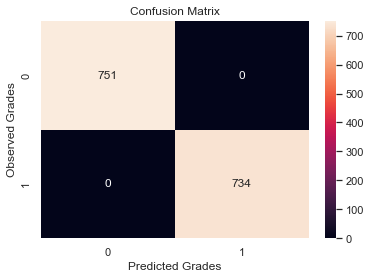

In [37]:
decision_tree_classifier = grid_search.best_estimator_
dtc_prediction = decision_tree_classifier.predict(X_test)

best_dtc_classification_report = classification_report(y_test, dtc_prediction, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{classification_report(y_test, dtc_prediction)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_dtc = confusion_matrix(y_test, dtc_prediction)

sb.heatmap(confusion_matrix_dtc, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

**K-Nearest Neighbor**

Classification report:
              precision    recall  f1-score   support

        -1.0       0.90      0.97      0.93       751
         1.0       0.96      0.89      0.92       734

    accuracy                           0.93      1485
   macro avg       0.93      0.93      0.93      1485
weighted avg       0.93      0.93      0.93      1485




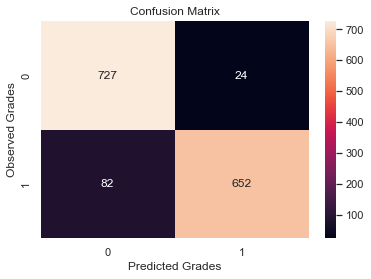

In [38]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)

knn_classification_report = classification_report(y_test, knn_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, knn_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_knn = confusion_matrix(y_test, knn_prediction)

sb.heatmap(confusion_matrix_knn, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

**Parameter Tunning**

In [39]:
parameter_grid = {'n_neighbors': [5,10,15,20],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid=parameter_grid,
                           scoring='precision_weighted',
                           cv=10,
                           n_jobs=3,
                           verbose=4)

grid_search.fit(X_train, y_train)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best score: 0.9348042936736759
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(algorithm='ball_tree', weights='distance')


--- Improved model ---

Classification report:
              precision    recall  f1-score   support

        -1.0       0.92      0.98      0.95       751
         1.0       0.97      0.91      0.94       734

    accuracy                           0.95      1485
   macro avg       0.95      0.95      0.95      1485
weighted avg       0.95      0.95      0.95      1485




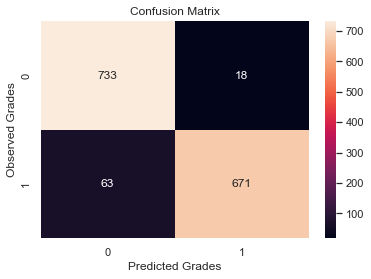

In [40]:
knn = grid_search.best_estimator_
yk_pred = knn.predict(X_test)

best_knn_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_knn = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_knn, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

**Support-Vector Machines**

Classification report:
              precision    recall  f1-score   support

        -1.0       0.70      0.67      0.68       751
         1.0       0.68      0.71      0.69       734

    accuracy                           0.69      1485
   macro avg       0.69      0.69      0.69      1485
weighted avg       0.69      0.69      0.69      1485




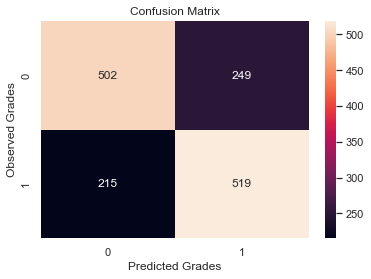

In [41]:
svc = SVC()

svc.fit(X_train, y_train)
svc_prediction = svc.predict(X_test)

svm_classification_report = classification_report(y_test, svc_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, svc_prediction)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_svm = confusion_matrix(y_test, svc_prediction)

sb.heatmap(confusion_matrix_svm, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

best_svm_classification_report = svm_classification_report

**Parameter Tunning**

In [42]:
parameter_grid = {'C' : [0.1, 1, 10], 
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(SVC(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=4)

grid_search.fit(X_train, y_train)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [ ]:
svc = grid_search.best_estimator_
yk_pred = svc.predict(X_test)

best_svm_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{best_knn_classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_svm = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_svm, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

**Neural Networks**

In [ ]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train_nn = scaler.transform(X_train)
X_test_nn = scaler.transform(X_test)

# Create the classifier
ANNClassifier = MLPClassifier(random_state=1, max_iter=500)

# Train the classifier on the training set
ANNClassifier.fit(X_train_nn, y_train)

predictions = ANNClassifier.predict(X_test_nn)

confusion_matrix_ann = confusion_matrix(y_test,predictions)

nn_classification_report = classification_report(y_test, predictions, output_dict=True)
print(classification_report(y_test,predictions))

sb.set(font_scale=1.0)

ax = plt.subplot()

sb.heatmap(confusion_matrix_ann, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

best_nn_classification_report = nn_classification_report

**Parameter Tunning**

In [ ]:
parameter_grid = {'activation': ['tanh','identity','logistic','relu'],
                  'solver': ['adam','lbfgs','sgd'],
                  'hidden_layer_sizes': [3,5,8,13,21,34],
                  'verbose': [True]}

cross_validation = StratifiedKFold(n_splits=10, shuffle=True)

grid_search = GridSearchCV(ANNClassifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

In [ ]:
ANNClassifier = grid_search.best_estimator_
yk_pred = ANNClassifier.predict(X_test)

best_nn_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{best_nn_classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_ann = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_ann, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()